In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from region_new import Region, emission_simple
from lclu.constant import lcz_cmap, lcz_hight

In [13]:
import os
import json
import numpy as np
import pickle
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

### how to create a database for a region
-  set a bounding box for the region, and init the **Region** class
- add basemap layers
    1. add vector (polygon) layer to this region
    2. bind data to polygons
- add MS buliding layer
- add OSB layer
- add raster layers
    1. add LCZ data
    2. add ...
- covert vector layer to raster layers
    1.sdf
- make output dataset
    1. interpolate needed raster layers to the same relostion
    2. merge all the selected layers as vars
- visualization  

In [14]:
# bounding boxes
bounding_box = json.load(open('bounding_box.json'))

In [15]:
# census data
tk_cen_path = os.path.join("data","census","tk_summary.xlsx")
za_cen_path = os.path.join("data","census","za_summary.xlsx")
eg_cen_path = os.path.join("data","census","eg_summary.xlsx")

tk_cen = pd.read_excel(tk_cen_path, "mean")
za_cen = pd.read_excel(za_cen_path, "mean")
eg_cen = pd.read_excel(eg_cen_path, "mean")
tk_cen = tk_cen.groupby(["region","city","year"]).mean().reset_index()
# we only take the most recent year
tk_cen = tk_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(tk_cen, on=["region","city","year"])
eg_cen = eg_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(eg_cen, on=["region","city","year"])

# tk_cen.loc[tk_cen["city"]=='Altınordu', "city"] = "Merkez"
# tk_cen.loc[tk_cen["city"]=='Ortahisar', "city"] = "Merkez"
tk_cen.loc[tk_cen["city"]=='Yunusemre', "city"] = "Merkez"
za_cen = za_cen.groupby(["region","city","year"]).mean().reset_index()
eg_cen = eg_cen.groupby(["region","city","year"]).mean().reset_index()

In [16]:
# house data
ordu_house = os.path.join("data","clipped_house","Ordu_house.pkl")
johannesburg_house = os.path.join("data","clipped_house","Johannesburg_house.pkl")
cairo_house = os.path.join("data","clipped_house","Cairo_house.pkl")
manisa_house = os.path.join("data","clipped_house","Manisa_house.pkl")
adana_house = os.path.join("data","clipped_house","Adana_house.pkl")
trabzon_house = os.path.join("data","clipped_house","Trabzon_house.pkl")

In [17]:
# lcz data
lcz_path = os.path.join ('data','lcz','lcz_filter_v1.tif')
lst_path = os.path.join ('data','lst','lst_2021_1.LST_Day_1km.tif')
ntl_path = os.path.join ('data','ntl','ntl_avg_2101.tif')


In [18]:
file = "gadm404.gpkg"
states =geopandas.read_file(os.path.join("data", "map",file))

tk = states.loc[states["SOVEREIGN"]=="Turkey"]
eg = states.loc[states["SOVEREIGN"]=="Egypt"]
za = states.loc[states["SOVEREIGN"]=="South Africa"]


In [20]:
cities = dict(
    Ordu = dict(
        box= bounding_box["Ordu"]["box"],
        level = "NAME_2",
        name = "Ordu",
        house = ordu_house,
        census = tk_cen,
        map= tk
    ),
    # Manisa = dict(
    #     box= bounding_box["Manisa"]["box"],
    #     level = "NAME_2",
    #     name = "Manisa",
    #     house = manisa_house,
    #     census = tk_cen,
    #     map= tk
    # ),
    # Adana = dict(
    #     box= bounding_box["Adana"]["box"],
    #     level = "NAME_2",
    #     name = "Adana",
    #     house = adana_house,
    #     census = tk_cen,
    #     map=tk
    # ),
    # Trabzon = dict(
    #     box= bounding_box["Trabzon"]["box"],
    #     level = "NAME_2",
    #     name = "Trabzon",
    #     house = trabzon_house,
    #     census = tk_cen,
    #     map=tk
    # ),
    
    # Cairo = dict(
    #     box= bounding_box["Cairo"]["box"],
    #     level = "NAME_2",
    #     name = "Cairo",
    #     house = cairo_house,
    #     census = eg_cen,
    #     map= eg
    # ),
    # Johannesburg = dict(
    #     box= bounding_box["Johannesburg"]["box"],
    #     level = "NAME_2",
    #     name = "Johannesburg",
    #     house = johannesburg_house,
    #     census = za_cen,
    #     map= za
    # ),
)

In [29]:
Cities = {}
resolution = (-500, 500)
# resolution = (-100, 100)
for index, (key, val) in enumerate(cities.items()):
    print(key)
    box, level, name, house, census, map = val["box"], val["level"],val["name"],val["house"],val["census"], val["map"]
    city = Region(val["box"])
    # add base map
    city.add_layer(layer_name="base_map", 
                   geo_data=map, 
                   layer_type="vector", 
                   box=box, 
                   level=level, 
                   meta="administrative divisions")
    # bind census data
    city.vector["base_map"].bound_data(census, "city")
    # add MS building
    house = pickle.load(open(house,"rb"))
    city.add_layer(layer_name="MS", 
                   geo_data=house, 
                   layer_type="vector", 
                   meta="MS buildings")
    # add lcz raster layer
    city.add_layer(layer_name="lcz", 
                   geo_data=lcz_path, 
                   layer_type="raster", 
                   box=box, 
                   var_name="lcz", 
                   meta="LCZ categorey label")
    # # add lst raster layer
    # city.add_layer(layer_name="lst", 
    #                geo_data=lst_path, 
    #                layer_type="raster", 
    #                box=box, 
    #                var_name="lst", 
    #                meta="LST")
    # # add ntl raster layer
    # city.add_layer(layer_name="ntl", 
    #                geo_data=ntl_path, 
    #                layer_type="raster", 
    #                box=box, 
    #                var_name="ntl", 
    #                meta="Nighttime Light")
    
    
    # convert vector to raster
    city.add_raster_from_vector(layer_name="MS", 
                                measurements=["area","density"], 
                                resolution=resolution, 
                                new_name = "MS_raster_100",
                                res_type="meter")
    
    city.add_raster_from_vector(layer_name="base_map", 
                                measurements=["population","household_number", "household_size"], 
                                resolution=resolution, 
                                new_name = "census_raster_100",
                                res_type="meter",
                                all_touched=False)
    
    # unify the projection
    city.unify_proj(crs_type="meter")
    
    # merge raster as output xarray
    city.merge_data(base_raster="MS_raster_100", 
                    raster_list={
                        "census_raster_100":(["population","household_number", "household_size"],"linear"),
                        "lcz":(["lcz"],"nearest"),
                        #"lst":(["lst"],"nearest"),
                        # "ntl":(["ntl"],"nearest")
                        }
                    )
    
    # calculate lcz height
    lcz_data =  city.output.lcz.data
    lcz_data[np.isnan(lcz_data)] = 0
    city.output.lcz.data = lcz_data.astype(int)
    city.output = city.output.assign(lcz_height = city.output.lcz)
    height = np.vectorize(lcz_hight.get)(city.output.lcz_height.data)
    height[height == None] = 0
    city.output.lcz_height.data = height.astype(float)
    
    # estiamte co2 emission with simple function
    city.output = city.output.assign(emission = emission_simple)
    
    Cities[key] = city
    

Ordu


c:\Users\czhou\anaconda3\envs\wb39_1\lib\site-packages\rasterio\windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


In [31]:
dump_path = os.path.join("data","Cities_v1.pickle")
with open(dump_path,"wb") as f:
    pickle.dump(Cities, f, protocol=pickle.HIGHEST_PROTOCOL)

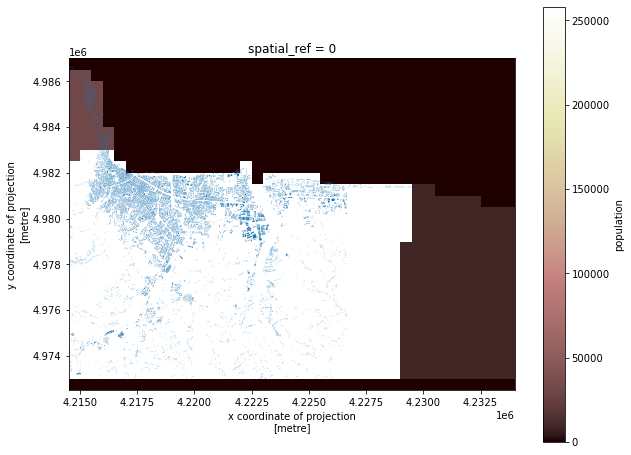

In [35]:
# population+MS building
# ax = Cities["Ordu"].vector["base_map"].geo_df.plot(column = "population", cmap="pink")
ax = Cities["Ordu"].vector["MS"].geo_df.plot(zorder=999,figsize=(10,8))
Cities["Ordu"].raster["census_raster_100"].tiff.population.plot(cmap="pink", ax=ax)

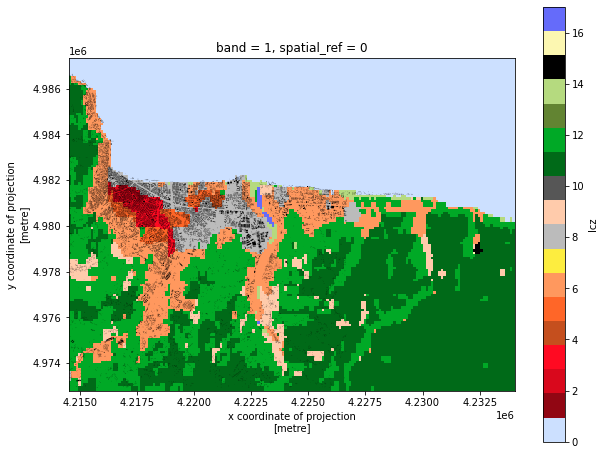

In [36]:
# lcz + MS building
ax =Cities["Ordu"].vector["MS"].geo_df.plot(zorder=999, color="k",figsize=(10,8))
Cities["Ordu"].raster["lcz"].tiff.lcz.plot(cmap=lcz_cmap, ax=ax)

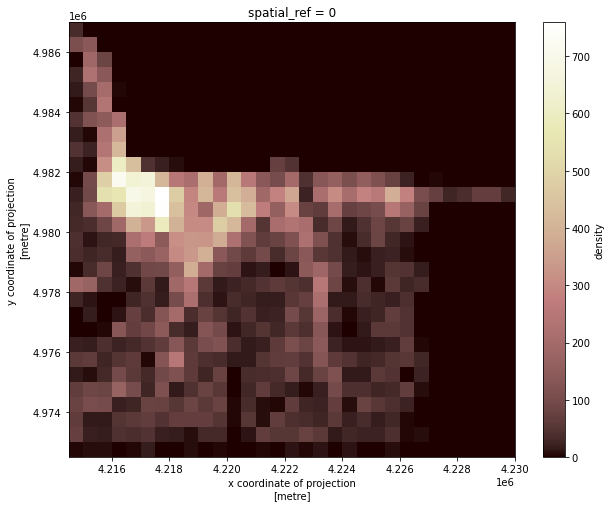

In [37]:
# building density
Cities["Ordu"].raster["MS_raster_100"].tiff.density.plot(cmap="pink",figsize=(10,8))

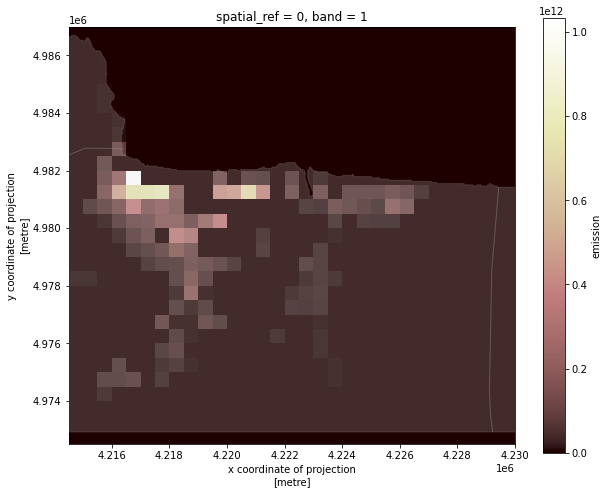

In [39]:
# emission
ax = Cities["Ordu"].vector["base_map"].geo_df.plot(zorder=999,  
                                                   alpha=0.2, 
                                                   color="#dbdbdb",
                                                   edgecolor="#a3a3a3",
                                                   figsize=(10,8))
Cities["Ordu"].output.emission.plot(ax=ax, cmap="pink")

In [15]:
# output database
Cities["Ordu"].output

<xarray.Dataset>
Dimensions:           (x: 154, y: 138, band: 1)
Coordinates:
  * x                 (x) float64 4.215e+06 4.215e+06 ... 4.23e+06 4.23e+06
  * y                 (y) float64 4.987e+06 4.987e+06 ... 4.973e+06 4.973e+06
    spatial_ref       int32 0
  * band              (band) int32 1
Data variables:
    area              (y, x) float64 339.9 1.772e+03 0.0 0.0 ... 0.0 0.0 0.0 0.0
    density           (y, x) float64 1.0 8.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    population        (y, x) float64 -3.638e-12 3.062e+04 ... 8.221e+03
    household_number  (y, x) float64 0.0 1.22e+04 ... 3.395e+03 3.395e+03
    household_size    (y, x) float64 0.0 2.39 2.39 0.0 ... 2.42 2.42 2.42 2.42
    lcz               (band, y, x) float64 nan 0.0 0.0 0.0 ... 11.0 11.0 11.0
    lcz_height        (band, y, x) float64 0.0 0.0 0.0 0.0 ... 0.1 0.1 0.1 0.1
    emission          (y, x, band) float64 -3.638e-12 2.449e+05 0.0 ... 0.0 0.0

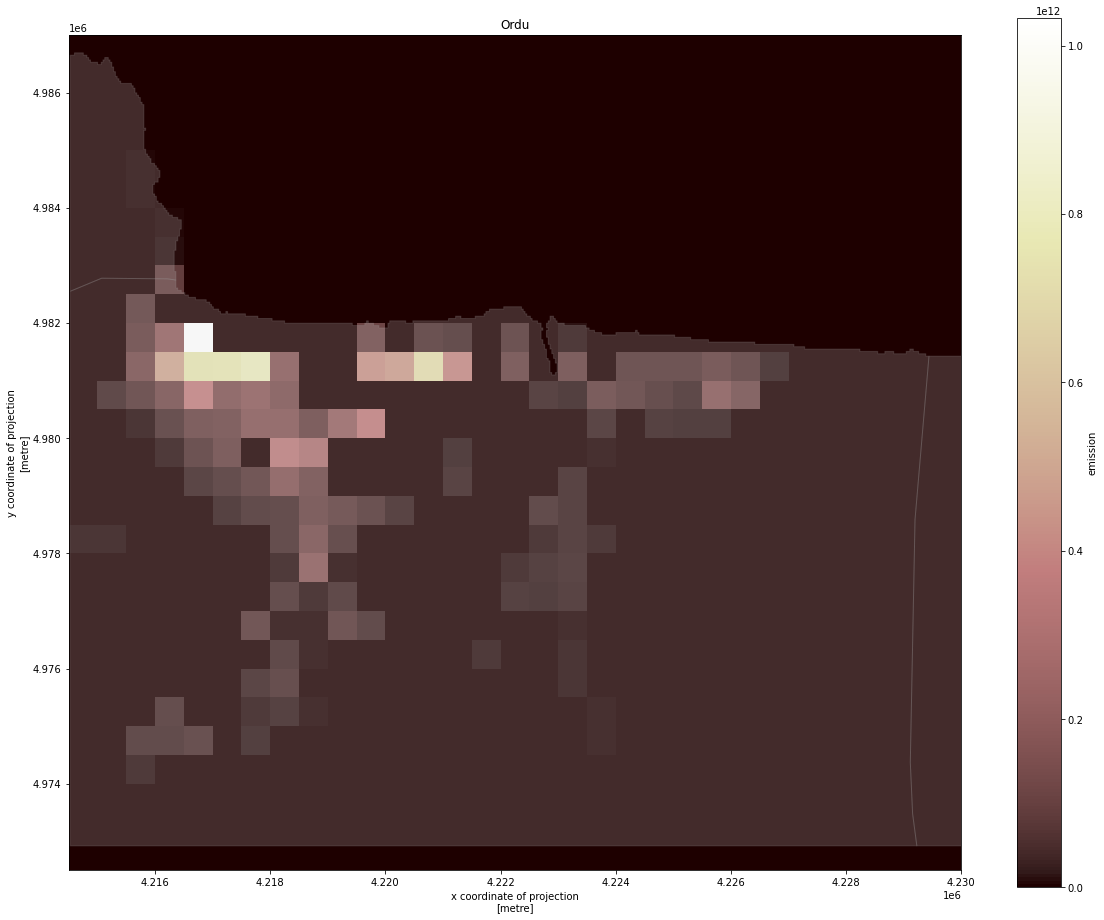

In [34]:
for index, (key, val) in enumerate(cities.items()):
    ax = Cities[key].vector["base_map"].geo_df.plot(zorder=999,  
                                                    alpha=0.2, 
                                                    color="#dbdbdb",
                                                    edgecolor="#a3a3a3",
                                                    figsize=(20,16))
    temp = Cities[key].output.emission.data
    temp[temp <0] = 0
    Cities[key].output.emission.data = temp
    Cities[key].output.emission.plot(ax=ax, cmap="pink")
    plt.title(key)
    